# Extracted Radar Columns and In-Situ Sensors (RadCLss) Dataset

## 17 March 2022 Case

In order to evaluate the SAIL field campaign snowfall retrievals, 
a dataset containing the radar column above each of our sites of interest, 
matched with in-situ ground observations is desired. 

## Current List of Supported In-Situ Ground Observations
- Pluvio Weighing Bucket Precipitation Gauge [WBPLUVIO2] (DOI: 10.5439/1338194)
- Surface Meteorological Instrumentation [MET] (DOI: 10.5439/1786358)
- Laser Disdrometer [LD] (DOI: 10.5439/1779709)
- Balloon-borne sounding system [SONDEWNPN] (DOI: 10.5439/1595321)
- Radar Wind Profiler [915RWPPRECIPMOMENTHIGH] 


## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from dask.distributed import Client, LocalCluster

import act
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Define Processing Variables

In [2]:
# Define the desired processing date for the CSU XPRECIPRADAR in YYYY-MM-DD format.
DATE = "2022-03-17"
# Define the directory where the CSU-X Band CMAC2.0 files are located.
RADAR_DIR = "/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/"
# Define an output directory for downloaded ground instrumentation
INSITU_DIR = '/Users/jrobrien/ARM/active/'

In [3]:
# Define ARM Username and ARM Token with ARM Live service for downloading ground instrumentation via ACT.DISCOVERY
# With your ARM username, you can find your ARM Live token here: https://adc.arm.gov/armlive/
ARM_USERNAME = os.getenv("ARM_USERNAME")
ARM_TOKEN = os.getenv("ARM_TOKEN")

## Define Functions 

In [4]:
def subset_points(file, **kwargs):
    """
    Subset a radar file for a set of latitudes and longitudes
    utilizing Py-ART's column-vertical-profile functionality.

    Parameters
    ----------
    file : str
        Path to the radar file to extract columns from
    nsonde : list
        List containing file paths to the desired sonde file to merge

    Calls
    -----
    radar_start_time
    merge_sonde

    Returns
    -------
    ds : xarray DataSet
        Xarray Dataset containing the radar column above a give set of locations
    
    """

    ds = None
    
    # Define the splash locations [lon,lat]
    kettle_ponds = [-106.9731488, 38.9415427]
    avery_point = [-106.9965928, 38.9705885]
    pumphouse_site = [-106.9502476, 38.9226741]
    M1 = [-106.987, 38.956158]
    snodgrass = [-106.978929, 38.926572]

    sites = ["M1", "kettle_ponds", "avery_point", "pumphouse_site", "snodgrass"]

    # Zip these together!
    lons, lats = list(zip(M1,
                          kettle_ponds,
                          avery_point,
                          pumphouse_site,
                          snodgrass))
    try:
        # Read in the file
        radar = pyart.io.read(file)
    except:
        radar = None

    if radar:
        # Easier to map the nearest sonde file to radar gates before extraction
        if 'sonde' in kwargs:

            # variables to discard when reading in the sonde file
            exclude_sonde = ['base_time', 'time_offset', 'lat', 'lon', 'qc_pres',
                             'qc_tdry', 'qc_dp', 'qc_wspd', 'qc_deg', 'qc_rh',
                             'qc_u_wind', 'qc_v_wind', 'qc_asc']
        
            # find the nearest sonde file to the radar start time
            radar_start = datetime.datetime.strptime(file.split('/')[-1].split('.')[-2], '%Y%m%d-%H%M%S')
            sonde_start = [datetime.datetime.strptime(xfile.split('/')[-1].split('.')[2] + 
                                                      '-' + 
                                                      xfile.split('/')[-1].split('.')[3], 
                                                      '%Y%m%d-%H%M%S') for xfile in kwargs['sonde']
                          ]
            # difference in time between radar file and each sonde file
            start_diff = [radar_start - sonde for sonde in sonde_start]

            # merge the sonde file into the radar object
            ds_sonde = act.io.read_arm_netcdf(nsonde[start_diff.index(min(start_diff))], 
                                              cleanup_qc=True, 
                                              drop_variables=exclude_sonde)
   
            # create list of variables within sonde dataset to add to the radar file
            for var in list(ds_sonde.keys()):
                if var != "alt":
                    z_dict, sonde_dict = pyart.retrieve.map_profile_to_gates(ds_sonde.variables[var],
                                                                             ds_sonde.variables['alt'],
                                                                             radar)
                # add the field to the radar file
                radar.add_field_like('DBZ', "sonde_" + var,  sonde_dict['data'], replace_existing=True)
                radar.fields["sonde_" + var]["units"] = sonde_dict["units"]
                radar.fields["sonde_" + var]["long_name"] = sonde_dict["long_name"]
                radar.fields["sonde_" + var]["standard_name"] = sonde_dict["standard_name"]
                radar.fields["sonde_" + var]["datastream"] = ds_sonde.datastream

            del radar_start, sonde_start, ds_sonde
            del z_dict, sonde_dict
        
        column_list = []
        for lat, lon in zip(lats, lons):
            # Make sure we are interpolating from the radar's location above sea level
            # NOTE: interpolating throughout Troposphere to match sonde to in the future
            #da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(np.round(radar.altitude['data'][0]), 10100, 100))
            #da = pyart.util.columnsect.column_vertical_profile(radar, lat, lon).interp(height=np.arange(np.round(radar.altitude['data'][0]), 10100, 100))
            da = pyart.util.columnsect.column_vertical_profile(radar, lat, lon).interp(height=np.arange(3150, 10050, 50))
            # Add the latitude and longitude of the extracted column
            da["latitude"], da["longitude"] = lat, lon
            # Time is based off the start of the radar volume
            dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
            da["time"] = [dt]
            column_list.append(da)
        
        # Concatenate the extracted radar columns for this scan across all sites    
        ds = xr.concat(column_list, dim='site')
        ds["site"] = sites
        # Add attributes for Time, Latitude, Longitude, and Sites
        ds.time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
                                        + " of each Individual Radar Volume Scan before"
                                        + " Concatenation"),
                             description=('Time in Seconds that Cooresponds to the Minimum'
                                          + ' Height Gate'))
        ds.site.attrs.update(long_name="SAIL/SPLASH In-Situ Ground Observation Site Identifers")
        ds.latitude.attrs.update(long_name='Latitude of SAIL Ground Observation Site',
                                 units='Degrees North')
        ds.longitude.attrs.update(long_name='Longitude of SAIL Ground Observation Site',
                                 units='Degrees East')
        # delete the radar to free up memory
        del radar, column_list, da
    return ds

In [5]:
def match_datasets_act(column, ground, site, discard, resample='sum', DataSet=False):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations using the ARM ACT package
    
    Parameters
    ----------
    column : Xarray DataSet
        Xarray DataSet containing the extracted radar column above multiple locations.
        Dimensions should include Time, Height, Site
             
    ground : str; Xarray DataSet
        String containing the path of the ground instrumentation file that is desired
        to be included within the extracted radar column dataset. 
        If DataSet is set to True, ground is Xarray Dataset and will skip I/O. 
             
    site : str
        Location of the ground instrument. Should be included within the filename. 
        
    discard : list
        List containing the desired input ground instrumentation variables to be 
        removed from the xarray DataSet. 
    
    resample : str
        Mathematical operational for resampling ground instrumentation to the radar time.
        Default is to sum the data across the resampling period. Checks for 'mean' or 
        to 'skip' altogether. 
    
    DataSet : boolean
        Boolean flag to determine if ground input is an Xarray Dataset.
        Set to True if ground input is Xarray DataSet. 
             
    Returns
    -------
    ds : Xarray DataSet
        Xarray Dataset containing the time-synced in-situ ground observations with
        the inputed radar column 
    """
    # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file using ACT
        grd_ds = act.io.read_arm_netcdf(ground, cleanup_qc=True, drop_variables=discard)
        # Default are Lazy Arrays; convert for matching with column
        grd_ds = grd_ds.compute()
        # Check to see if file is the RWP, 
        if 'rwp' in ground[0].split('/')[-1]:
            # adjust the RWP heights above ground level
            grd_ds['height'] = grd_ds.height.data + grd_ds.alt.data
        if 'ceil' in ground[0].split('/')[-1]:
            # correct ceilometer backscatter 
            grd_ds = act.corrections.correct_ceil(grd_ds, var_name='backscatter')
            # Rename the range dimension and apply altitude 
            grd_ds = grd_ds.rename({'range' : 'height'})
            grd_ds['height'] = grd_ds.height.data + grd_ds.alt.data
        
    # Remove Base_Time before Resampling Data since you can't force 1 datapoint to 5 min sum
    if 'base_time' in grd_ds.data_vars:
        del grd_ds['base_time']
        
    # Check to see if height is a dimension within the ground instrumentation. 
    # If so, first interpolate heights to match radar, before interpolating time.
    if 'height' in grd_ds.dims:
        grd_ds = grd_ds.interp(height=np.arange(3150, 10050, 50), method='linear')
        
    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    if resample.split('=')[-1] == 'mean':
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').mean(keep_attrs=True).interp(time=column.time, 
                                                                               method='linear')
    elif resample.split('=')[-1] == 'skip':
        matched = grd_ds.interp(time=column.time, method='linear')
    else:
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').sum(keep_attrs=True).interp(time=column.time, 
                                                                              method='linear')
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(site=site))
    matched = matched.expand_dims('site')
   
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
    if 'alt' in matched.data_vars:
        del matched['alt']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(source=matched.datastream)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
   
    return column

## Find / Download In-Situ Files

In [6]:
insitu_streams = ['gucwbpluvio2M1.a1', 
                  'gucmetM1.b1', 
                  'gucldM1.b1', 
                  'gucldS2.b1', 
                  'guc915rwpprecipmeanlowM1.a1', 
                  'gucsondewnpnM1.b1',
                  'gucceilM1.b1']
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    for insitu in insitu_streams:
        results = act.discovery.download_arm_data(ARM_USERNAME, 
                                                  ARM_TOKEN, 
                                                  insitu, 
                                                  DATE, 
                                                  DATE, 
                                                  output=INSITU_DIR)

[DOWNLOADING] gucwbpluvio2M1.a1.20220317.000000.nc

If you use these data to prepare a publication, please cite:

Wang, D., Jane, M., Cromwell, E., Sturm, M., Irving, K., Delamere, J., &
Mockaitis, M. Weighing Bucket Precipitation Gauge (WBPLUVIO2). Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1338194

[DOWNLOADING] gucmetM1.b1.20220317.000000.cdf

If you use these data to prepare a publication, please cite:

Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

[DOWNLOADING] gucldM1.b1.20220317.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi, Y. Laser Disdrometer (LD). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1973058

[DOWNLOADING] gucldS2.b1.20220317.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi,

## List the Available CSU X-Band Corrected Precipitation Radar Moments in Antenna Coordinates Version 2 (CMAC2.0) Files

#### In contrast to the Merged CSU X-Band files previously used, the CSU X-Band CMAC2.0 files have been corrected for beam blockage and clutter, as well as, undergone additional processing. 

#### Z-S Relationships previously explored are applied during the CMAC2.0 processing of the CSU X-Band data. Therefore, all we need to do now is extract the radar columns and combine with ground instruments. 

In [7]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADAR_DIR + 'gucxprecipradarcmacM1.c1.' + DATE.replace('-', '') + '*.nc'))
file_list[:10]

['/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-002422.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-004022.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-004543.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-005103.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-010143.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-011743.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-012303.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-012823.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac_v2/gucxprecipradarcmacM1.c1.20220317-013343.nc',
 '/Users/jrobrien/ANL/Instruments/CSU-XPrecipRadar/cmac

In [8]:
nsonde = sorted(glob.glob(INSITU_DIR + "*gucsondewnpnM1.b1." + DATE.replace('-', '') + '*'))

In [9]:
%%time
## Start up a Dask Cluster
cluster = LocalCluster(n_workers=4)
with Client(cluster) as client:
    future = client.map(subset_points, file_list[:60], sonde=nsonde)
    my_data = client.gather(future)

CPU times: user 7.85 s, sys: 2.64 s, total: 10.5 s
Wall time: 3min 7s


## Combine all Extracted Radar Columns to Form Daily Timeseries

In [10]:
# Concatenate all extracted columns across time dimension to form daily timeseries
ds = xr.concat([data for data in my_data if data], dim='time')

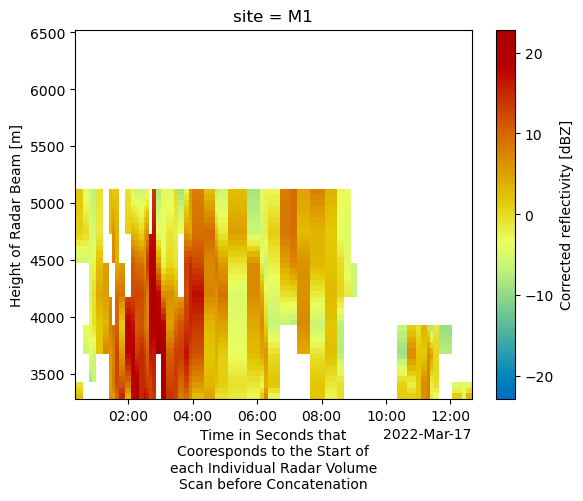

In [11]:
ds.sel(site='M1').sel(height=slice(3300, 6500)).corrected_reflectivity.plot(x='time',
                                                                            cmap='pyart_HomeyerRainbow')

In [12]:
# Remove Global Attributes from the Column Extraction
# Attributes make sense for single location, but not collection of sites. 
ds.attrs = {}

In [13]:
# Remove the Base_Time variable from extracted column
del ds['base_time']

In [14]:
ds

<xarray.Dataset> Size: 15MB
Dimensions:                                   (time: 60, site: 5, height: 138)
Coordinates:
  * height                                    (height) int64 1kB 3150 ... 10000
  * time                                      (time) datetime64[ns] 480B 2022...
  * site                                      (site) <U14 280B 'M1' ... 'snod...
Data variables: (12/46)
    DBZ                                       (time, site, height) float64 331kB ...
    VEL                                       (time, site, height) float64 331kB ...
    WIDTH                                     (time, site, height) float64 331kB ...
    ZDR                                       (time, site, height) float64 331kB ...
    PHIDP                                     (time, site, height) float64 331kB ...
    RHOHV                                     (time, site, height) float64 331kB ...
    ...                                        ...
    sonde_wstat                               (time, site, height) float64 331kB ...
    sonde_asc                                 (time, site, height) float64 331kB ...
    sonde_alt                                 (time, site, height) float64 331kB ...
    time_offset                               (time, site, height) float64 331kB ...
    latitude                                  (time, site) float64 2kB 38.96 ...
    longitude                                 (time, site) float64 2kB -107.0...

## Define Dictionary of Variables to Remove from Each Datastream

In [15]:
discard_var = {'LD' : ['base_time', 'time_offset', 'equivalent_radar_reflectivity_ott',
                       'laserband_amplitude', 'sensor_temperature', 'heating_current', 'sensor_voltage', 
                       'moment1', 'moment2', 'moment3', 'moment4',
                       'moment5', 'moment6', 'lat', 'lon', 'alt',
                       'qc_precip_rate', 'qc_weather_code', 'qc_equivalent_radar_reflectivity_ott',
                       'qc_number_detected_particles', 'qc_mor_visibility', 'qc_snow_depth_intensity',
                       'qc_laserband_amplitude', 'qc_heating_current', 'qc_sensor_voltage'
                      ],
               'Pluvio' : ['base_time', 'time_offset', 'load_cell_temp', 'heater_status',
                          'elec_unit_temp', 'supply_volts', 'orifice_temp', 'volt_min',
                          'ptemp', 'lat', 'lon', 'alt', 'maintenance_flag', 'reset_flag', 
                          'qc_rh_mean', 'pluvio_status'
                          ],
               'Met' : ['base_time', 'time_offset', 'time_bounds', 'logger_volt',
                        'logger_temp', 'qc_logger_temp', 'lat', 'lon', 'alt', 'qc_temp_mean',
                        'qc_rh_mean', 'qc_vapor_pressure_mean', 'qc_wspd_arith_mean', 'qc_wspd_vec_mean',
                        'qc_wdir_vec_mean', 'qc_pwd_mean_vis_1min', 'qc_pwd_mean_vis_10min', 'qc_pwd_pw_code_inst',
                        'qc_pwd_pw_code_15min', 'qc_pwd_pw_code_1hr', 'qc_pwd_precip_rate_mean_1min',
                        'qc_pwd_cumul_rain', 'qc_pwd_cumul_snow', 'qc_org_precip_rate_mean', 'qc_tbrg_precip_total',
                        'qc_tbrg_precip_total_corr', 'qc_logger_volt', 'qc_logger_temp', 'qc_atmos_pressure', 
                        'pwd_pw_code_inst', 'pwd_pw_code_15min', 'pwd_pw_code_1hr', 
                       ],
               'RWP' : ['base_time', 'time_offset', 'time_bounds', 'height_bounds', 'vertical_wind_speed_count',
                        'vertical_wind_speed_quality_flag', 'lat', 'lon'
                       ],
               'ceil': ['base_time', 'time_offset', 'time_bounds', 'range_bounds', 'detection_status',
                        'status_flag', 'qc_first_cbh', 'qc_vertical_visibility', 'qc_second_cbh', 'qc_alt_highest_signal', 
                        'qc_third_cbh', 'laser_pulse_energy', 'qc_laser_pulse_energy', 'laser_temperature', 'qc_laser_temperature',
                        'window_transmission', 'qc_window_transmission', 'tilt_angle', 'qc_tilt_angle', 'background_light',
                        'qc_background_light', 'sum_backscatter', 'qc_sum_backscatter', 'measurement_parameters', 'status_string',
                        'alt_highest_signal', 'lat', 'lon'
                       ]
              }

## Add in the Pluvio Weighing Bucket Data

In [16]:
# Define the file path
npluvio = sorted(glob.glob(INSITU_DIR + '*gucwbpluvio2M1.a1.' + DATE.replace('-','') + '*'))
# Define the site location based on the filename
pluv_site = npluvio[0].split('gucwbpluvio2')[-1].split('.')[0]

In [17]:
# Call Match Datasets ACT 
ds = match_datasets_act(ds, npluvio[0], pluv_site, discard=discard_var['Pluvio'])

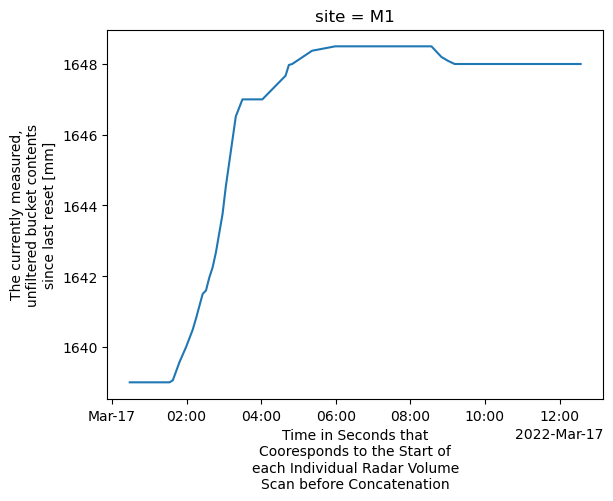

In [18]:
# Plot the Weighing Bucket accumulation at the M1 site
# Test to make sure Pluvio is correctly merged in with extracted column. 
ds.sel(site='M1').bucket_rt.plot(x='time')

## Add the Surface Meteorological Station (MET) to the Matched Dataset

In [19]:
# Define the file path
nmet = sorted(glob.glob(INSITU_DIR + '*gucmetM1.b1.' + DATE.replace('-', '') + '*'))
# Define the site location based on the filename
met_site = nmet[0].split('gucmet')[-1].split('.')[0]

In [20]:
# Call Match Datasets ACT
ds = match_datasets_act(ds, nmet[0], met_site, discard=discard_var['Met'])

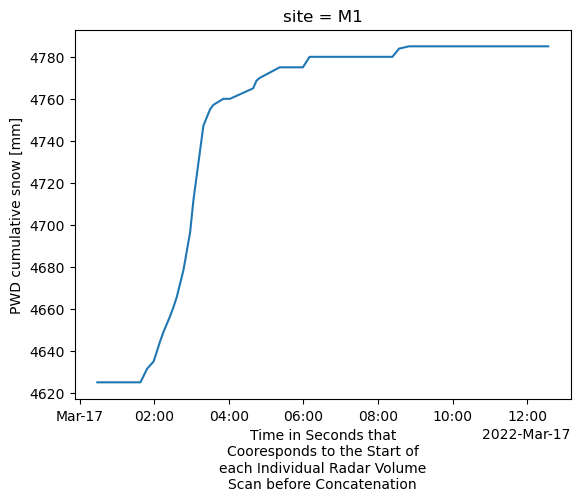

In [21]:
# Plot the MET accumulation at the M1 site
# Test to make sure MET is correctly merged in with extracted column. 
ds.sel(site='M1').pwd_cumul_snow.plot(x='time')

## Add the Laser Disdrometer to the Matched Dataset  - M1 Sites

In [22]:
# Define the file path
nld = sorted(glob.glob(INSITU_DIR + '*gucldM1.b1.' + DATE.replace('-', '') + '*'))
# Define the site location based on the filename
ld_site = nld[0].split('gucld')[-1].split('.')[0]

In [23]:
# Call Match Datasets ACT
ds = match_datasets_act(ds, nld[0], ld_site, discard=discard_var['LD'])

## Add Second Laser Disdrometer - S2 Site

In [24]:
# Define the file path
ld_2 = sorted(glob.glob(INSITU_DIR + '*gucldS2.b1.' + DATE.replace('-', '') + '*'))
# Define the site location based on the filename
ld2_site = ld_2[0].split('gucld')[-1].split('.')[0]

In [25]:
# Call Match Datasets ACT
ds = match_datasets_act(ds, ld_2[0], ld2_site, discard=discard_var['LD'])

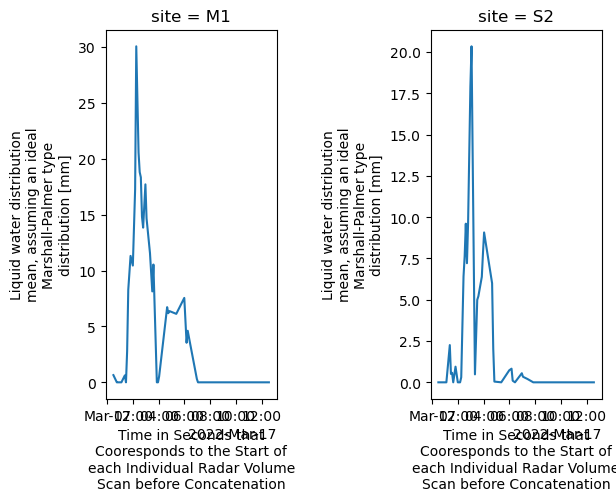

In [26]:
# Sanity Check - Plot LD from M1 and S2 sites to verify datastreams merged correctly
fig, axarr = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.9, hspace=1.2)

ds.liquid_water_distribution_mean.sel(site='M1').plot(ax=axarr[0])
ds.liquid_water_distribution_mean.sel(site='S2').plot(ax=axarr[1])

## Add the Radar Wind Profiler (Precipitation Mode - Mean)

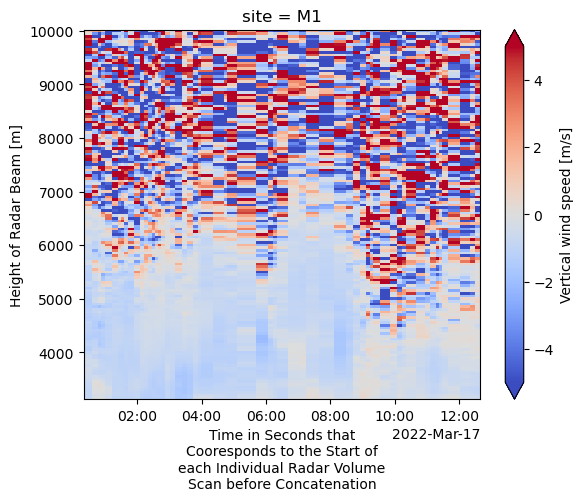

In [27]:
# Define the file path
nrwp = sorted(glob.glob(INSITU_DIR + '*guc915rwpprecipmeanlowM1.a1.' + DATE.replace('-', '') + '*'))
if len(nrwp) > 0:

    # Call Match Datasets ACT
    ds = match_datasets_act(ds, nrwp, 'M1', resample='skip', discard=discard_var['RWP'])

    # Check to make sure the RWP datastream merged in correctly
    ds.sel(site='M1').vertical_wind_speed.plot(y='height', cmap='coolwarm', vmin=-5, vmax=5)

## Add the Ceilometer Data 

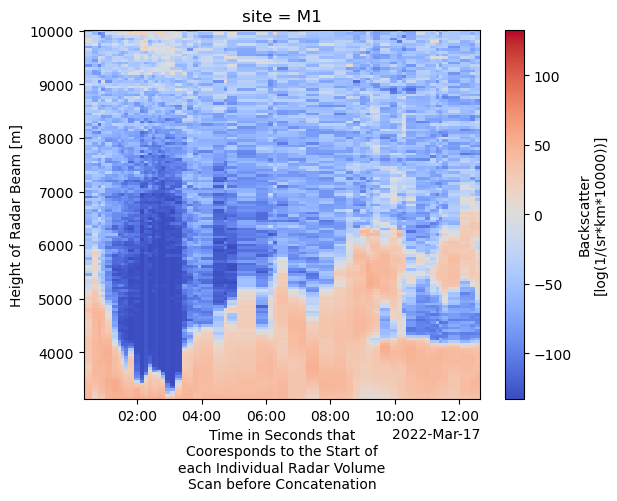

In [28]:
# Define the file path
nceil = sorted(glob.glob(INSITU_DIR + '*gucceilM1.b1.' + DATE.replace('-', '') + '*'))
if len(nceil) > 0:

    # Call Match Datasets ACT
    ds = match_datasets_act(ds, nceil, 'M1', discard=discard_var['ceil'])

    # Check to make sure the RWP datastream merged in correctly
    ds.sel(site='M1').backscatter.plot(y='height', cmap='coolwarm')

In [29]:
ds

<xarray.Dataset> Size: 22MB
Dimensions:                                   (height: 138, time: 60, site: 6,
                                               particle_size: 32,
                                               raw_fall_velocity: 32)
Coordinates:
  * height                                    (height) int64 1kB 3150 ... 10000
  * time                                      (time) datetime64[ns] 480B 2022...
  * site                                      (site) <U14 336B 'M1' ... 'snod...
  * particle_size                             (particle_size) float32 128B 0....
  * raw_fall_velocity                         (raw_fall_velocity) float32 128B ...
Data variables: (12/99)
    DBZ                                       (time, site, height) float64 397kB ...
    VEL                                       (time, site, height) float64 397kB ...
    WIDTH                                     (time, site, height) float64 397kB ...
    ZDR                                       (time, site, height) float64 397kB ...
    PHIDP                                     (time, site, height) float64 397kB ...
    RHOHV                                     (time, site, height) float64 397kB ...
    ...                                        ...
    vertical_wind_speed_std                   (site, time, height) float64 397kB ...
    first_cbh                                 (site, time) float64 3kB 3.286e...
    vertical_visibility                       (site, time) float64 3kB 0.0 .....
    second_cbh                                (site, time) float64 3kB 1.758e...
    third_cbh                                 (site, time) float64 3kB 4.505e...
    backscatter                               (site, time, height) float64 397kB ...

## Define the Meta Data Standards for Matched Dataset

In [30]:
# Call the Data Object Definitions for this datastream. 
# Will create an xarray dataset which will contain the necessary meta data and variables. 
mdims = {"time": ds['time'].data.shape[0], "height": 138, "site": 6, "particle_size": 32, "raw_fall_velocity": 32}
out_ds = act.io.arm.create_ds_from_arm_dod('xprecipradarradclss.c2', mdims, version='1.2')

In [31]:
out_ds

<xarray.Dataset> Size: 21MB
Dimensions:                                   (time: 60, height: 138, site: 6,
                                               particle_size: 32,
                                               raw_fall_velocity: 32)
Coordinates:
  * time                                      (time) int64 480B 0 1 2 ... 58 59
  * height                                    (height) int64 1kB 0 1 ... 136 137
  * site                                      (site) int64 48B 0 1 2 3 4 5
  * particle_size                             (particle_size) int64 256B 0 .....
  * raw_fall_velocity                         (raw_fall_velocity) int64 256B ...
Data variables: (12/100)
    DBZ                                       (time, height, site) float64 397kB ...
    VEL                                       (time, height, site) float64 397kB ...
    WIDTH                                     (time, height, site) float64 397kB ...
    ZDR                                       (time, height, site) float64 397kB ...
    PHIDP                                     (time, height, site) float64 397kB ...
    RHOHV                                     (time, height, site) float64 397kB ...
    ...                                        ...
    second_cbh                                (time, site) float64 3kB -9.999...
    third_cbh                                 (time, site) float64 3kB -9.999...
    backscatter                               (time, height, site) float64 397kB ...
    lat                                       (site) float64 48B -9.999e+03 ....
    lon                                       (site) float64 48B -9.999e+03 ....
    alt                                       (time, site) float64 3kB -9.999...
Attributes: (12/24)
    command_line:          
    Conventions:           ARM-1.3 CF/Radial instrument_parameters
    process_version:       
    dod_version:           
    input_datastreams:     
    site_id:               
    ...                    ...
    developers:            Joseph O'Brien, ANL. Maxwell Grover, ANL. Robert J...
    translator:            https://www.arm.gov/capabilities/instruments/xprec...
    mentors:               https://www.arm.gov/connect-with-arm/organization/...
    source:                Colorado State University's X-Band Precipitation R...
    field_names:           DBZ, VEL, WIDTH, ZDR, PHIDP, RHOHV, NCP, DBZhv, cb...
    history:

In [32]:
# Transform the matched dataset for consistent dimensions
ds = ds.transpose('time', 'height', 'site', 'particle_size', 'raw_fall_velocity')

In [33]:
# Output Dataset has correct data attributes, supplied by the DOD. 
# Update the output dataset variable values with the matched dataset. 
for var in out_ds.variables:
    if var not in out_ds.dims:
        # check to see if variable is within the matched dataset
        # note: it may not be if file is missing.
        if var in ds.variables:
            out_ds[var].data = ds[var].data

In [34]:
# Update the coordinates with the matched dataset values
out_ds = out_ds.assign_coords(time = ds['time'].data, 
                              height = ds['height'].data, 
                              site = ds['site'].data, 
                              particle_size = ds['particle_size'].data,
                              raw_fall_velocity = ds['raw_fall_velocity'].data)

In [35]:
out_ds

<xarray.Dataset> Size: 21MB
Dimensions:                                   (time: 60, height: 138, site: 6,
                                               particle_size: 32,
                                               raw_fall_velocity: 32)
Coordinates:
  * time                                      (time) datetime64[ns] 480B 2022...
  * height                                    (height) int64 1kB 3150 ... 10000
  * site                                      (site) <U14 336B 'M1' ... 'snod...
  * particle_size                             (particle_size) float32 128B 0....
  * raw_fall_velocity                         (raw_fall_velocity) float32 128B ...
Data variables: (12/100)
    DBZ                                       (time, height, site) float64 397kB ...
    VEL                                       (time, height, site) float64 397kB ...
    WIDTH                                     (time, height, site) float64 397kB ...
    ZDR                                       (time, height, site) float64 397kB ...
    PHIDP                                     (time, height, site) float64 397kB ...
    RHOHV                                     (time, height, site) float64 397kB ...
    ...                                        ...
    second_cbh                                (time, site) float64 3kB 1.758e...
    third_cbh                                 (time, site) float64 3kB 4.505e...
    backscatter                               (time, height, site) float64 397kB ...
    lat                                       (site) float64 48B -9.999e+03 ....
    lon                                       (site) float64 48B -9.999e+03 ....
    alt                                       (time, site) float64 3kB -9.999...
Attributes: (12/24)
    command_line:          
    Conventions:           ARM-1.3 CF/Radial instrument_parameters
    process_version:       
    dod_version:           
    input_datastreams:     
    site_id:               
    ...                    ...
    developers:            Joseph O'Brien, ANL. Maxwell Grover, ANL. Robert J...
    translator:            https://www.arm.gov/capabilities/instruments/xprec...
    mentors:               https://www.arm.gov/connect-with-arm/organization/...
    source:                Colorado State University's X-Band Precipitation R...
    field_names:           DBZ, VEL, WIDTH, ZDR, PHIDP, RHOHV, NCP, DBZhv, cb...
    history:

## Save the DataSet

In [36]:
# define a filename
out_ds.to_netcdf('xprecipradarradclss.c2.' + DATE.replace('-', '') + '.000000.nc')